In [1]:
print("Hello World")

Hello World


The next stage of the project is looking at the algorithims, and working with a reduced set of dimensions, looking at imporving our random forest and trying other algorithims

In [2]:
readFile="Data/parquet/subSampleWholeDataSet"

In [3]:
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt 
from pyspark.sql.functions import col

In [4]:
spark = SparkSession.builder \
    .master("local") \
    .appName("WiFi") \
    .config("spark.driver.memory", "8g")\
    .getOrCreate()

In [5]:
df=spark.read.parquet(readFile)

In [6]:
df.groupBy('StringLabel').count().show()
df.count()

+----------------+------+
|     StringLabel| count|
+----------------+------+
|           Krack|  2500|
|             SSH|  3541|
|          Botnet|  2725|
|            SSDP|  2622|
|   SQL_Injection|  2629|
|         RogueAP|  1310|
|       Evil_Twin|  3088|
|Website_spoofing|  2397|
|       (Re)Assoc|  3331|
|           Disas|  2957|
|          Normal|596802|
|          Deauth|  2249|
|           Kr00k|  3758|
|         Malware|  2498|
+----------------+------+



632407

https://docs.microsoft.com/en-us/azure/databricks/_static/notebooks/getting-started/get-started-with-mllib-dbr7.html as a guide

In [7]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

To start we will run our grid search only using the dimensions that our individual attack searches showed were responsible for most of the explanation. Dealing with all the attacks together is a much harder problems. These dimensions are:

 'wlan_fixed_reason_code' Diassaciation, Deauthentication
 'wlan_tag_length' Reassociation
 'wlan_country_info_fnm', Rogue_AP
 'wlan_da' Rogue_AP
 'radiotap_channel_freq', Krack, Krook
 'wlan_da', SSH, Botnet, Malware, Website Spoofing
 'wlan_sa' SSH, Malware, Website Spoofing
 'ip_dst', Botnet, Malware, SQL Injection
 'ip_src' Botnet, SQL Injection
 'udp_length', SSDP
 'wlan_bssid' Evil Twin


In [8]:
categoricalCols = [
    "wlan_tag_length",
    "wlan_country_info_fnm",
    "wlan_da",
    "wlan_sa",
    "wlan_bssid",
    "ip_src",
    "ip_dst"
]
   


In [9]:
# The following two lines are estimators. They return functions that we will later apply to transform the dataset.
stringIndexer = StringIndexer(inputCols=categoricalCols, outputCols=[x + "index" for x in categoricalCols]).setHandleInvalid("keep") 
encoder = OneHotEncoder(inputCols=stringIndexer.getOutputCols(), outputCols=[x + "OHE" for x in categoricalCols]) 

In [10]:
numericCols=[
    "wlan_fixed_reason_code",
    "radiotap_channel_freq",
    "udp_length"
]

In [11]:
from pyspark.ml.feature import VectorAssembler
 
# This includes both the numeric columns and the one-hot encoded binary vector columns in our dataset.
assemblerInputs = [c + "OHE" for c in categoricalCols] + numericCols
vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

In [12]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

we want to do a test train split on our subsample

In [13]:
train, test = df.randomSplit([0.8,0.2])


In [14]:
print('Events for the training {}'.format(train.count()))
print('Events for the validation {}'.format(test.count()))

Events for the training 505541
Events for the validation 126866


we take a subsample and cache it for the grid search

In [15]:
gridSample = train.sample(fraction=1.0/25, withReplacement=False).cache()
print('We will use',gridSample.count(),' events for the grid search.')
gridSample.groupBy('label').count().show()
gridSample.groupBy('StringLabel').count().show()

We will use 20248  events for the grid search.
+-----+-----+
|label|count|
+-----+-----+
|    1| 1097|
|    0|19151|
+-----+-----+

+----------------+-----+
|     StringLabel|count|
+----------------+-----+
|           Krack|   65|
|             SSH|  112|
|          Botnet|   82|
|   SQL_Injection|   87|
|         RogueAP|   34|
|Website_spoofing|   73|
|       (Re)Assoc|  130|
|           Disas|   78|
|          Normal|19151|
|          Deauth|   76|
|           Kr00k|  113|
|       Evil_Twin|   86|
|         Malware|   81|
|            SSDP|   80|
+----------------+-----+



In [16]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol='label', featuresCol='features', 
                            maxBins=20, subsamplingRate=0.7,
                            minInfoGain= 1e-05,
                            featureSubsetStrategy='all',
                            minInstancesPerNode=2)

evaluator=BinaryClassificationEvaluator(metricName='areaUnderPR')
rf_pipe = Pipeline(stages=[stringIndexer, encoder, vecAssembler,rf])





paramGrid = ParamGridBuilder()\
  .addGrid(rf.maxDepth, [10,20])\
  .addGrid(rf.numTrees, [50])\
  .build()

cv = CrossValidator(estimator=rf_pipe, 
                    evaluator=evaluator,
                    estimatorParamMaps=paramGrid,
                    numFolds=2, parallelism=4)

In [17]:
%%time
bestModel = cv.fit(gridSample)
 

CPU times: user 475 ms, sys: 170 ms, total: 645 ms
Wall time: 3min 15s


In [18]:
print('BestModel:\n\t-maxDepth =',bestModel.bestModel.stages[-1]._java_obj.getMaxDepth())
print('\t-Feature Importance =',bestModel.bestModel.stages[-1]._java_obj.featureImportances())
print('BestModel:\n\t-maxDepth =',bestModel.bestModel.stages[-1]._java_obj.getNumTrees())

BestModel:
	-maxDepth = 20
	-Feature Importance = (1238,[0,1,3,4,5,7,8,9,11,12,13,14,15,16,17,18,20,23,24,25,26,27,29,31,33,34,35,38,41,64,65,68,75,80,81,82,83,84,85,87,88,89,96,97,98,99,128,130,132,150,153,156,163,167,171,675,1235,1236,1237],[0.09279369849394918,0.03286292196780466,0.007950231562010818,0.003344030397251543,5.214761957185102E-4,0.0037598021988920053,0.002647650095915312,9.616559563111539E-5,3.307104004691995E-4,1.1247922768065197E-4,5.7901777544008746E-5,5.2500735771821916E-5,5.381557572898611E-5,1.0933625440646693E-4,3.954905893361447E-4,7.459676639224205E-6,0.025372429891040913,0.013170641308512721,5.062618330689645E-4,0.030951844999622332,8.969060989124423E-5,1.7938646116029443E-4,0.0028782708710796074,2.1319018131144654E-5,3.9965970288860655E-4,0.15682733189500328,2.1020511794097837E-4,2.9079428366121115E-4,3.878370372771966E-4,3.119810228272636E-4,2.215490426918365E-4,2.4319759609771625E-4,4.6338983121414887E-4,1.9523175553250247E-5,0.001107817241414777,8.15827112

In [19]:
transformedBestModel=bestModel.transform(gridSample)

In [20]:
import pandas as pd

p = pd.DataFrame(transformedBestModel.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+transformedBestModel.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

In [21]:
p.name

0                                   wlan_tag_lengthOHE_NA
1                                    wlan_tag_lengthOHE_4
2       wlan_tag_lengthOHE_7-8-4-52-1-2-20-5-26-22-8-1...
3       wlan_tag_lengthOHE_7-8-1-4-6-20-26-22-4-12-5-2-24
4                               wlan_tag_lengthOHE_177-24
                              ...                        
1233       ip_dstOHE_99.181.79.5-99.181.79.5-99.181.67.49
1234                               ip_dstOHE_99.80.71.186
1235                               wlan_fixed_reason_code
1236                                radiotap_channel_freq
1237                                           udp_length
Name: name, Length: 1238, dtype: object

In [22]:

from itertools import chain
attrs = sorted(
    (attr["idx"], attr["name"])
    for attr in (
        chain(*transformedBestModel.schema["features"].metadata["ml_attr"]["attrs"].values())
    )
) 

In [23]:
ImportanceArray=[
    (name,  bestModel.bestModel.stages[-1].featureImportances[idx])
    for idx, name in attrs
    if bestModel.bestModel.stages[-1].featureImportances[idx]
]

In [24]:
ImportanceArray.sort(key=lambda row: (row[1]), reverse=True)

In [25]:
ImportanceArray

[('wlan_saOHE_04:ed:33:e0:24:82', 0.2292421777091812),
 ('wlan_fixed_reason_code', 0.212953301383954),
 ('wlan_daOHE_04:ed:33:e0:24:82', 0.15682733189500328),
 ('wlan_tag_lengthOHE_NA', 0.09279369849394918),
 ('wlan_bssidOHE_0c:9d:92:54:fe:35', 0.08295130275102992),
 ('radiotap_channel_freq', 0.0585784983327919),
 ('wlan_tag_lengthOHE_4', 0.03286292196780466),
 ('wlan_daOHE_a4:b1:c1:91:4c:72', 0.030951844999622332),
 ('wlan_country_info_fnmOHE_1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1',
  0.025372429891040913),
 ('wlan_daOHE_0c:9d:92:54:fe:30', 0.013170641308512721),
 ('udp_length', 0.01068548712250954),
 ('wlan_tag_lengthOHE_7-8-1-4-6-20-26-22-4-12-5-2-24', 0.007950231562010818),
 ('ip_srcOHE_192.168.2.130', 0.006406631793327049),
 ('ip_srcOHE_192.168.2.248', 0.005238938000254544),
 ('wlan_saOHE_50:3e:aa:e4:01:93', 0.004703447524052169),
 ('wlan_tag_lengthOHE_8-1-1-5-26-22-8-5-12-5-9-24', 0.0037598021988920053),
 ('wlan_tag_lengthOHE_177-24', 0.003344030397251543),
 ('wlan_daOHE_0c:9d:92:54:fe:

In [26]:
len(bestModel.bestModel.stages[-1].featureImportances)

1238

In [27]:
gridSample.unpersist()

DataFrame[frame_encap_type: int, frame_len: int, frame_number: int, frame_time: string, frame_time_delta: double, frame_time_delta_displayed: double, frame_time_epoch: double, frame_time_relative: double, radiotap_channel_flags_cck: int, radiotap_channel_flags_ofdm: int, radiotap_channel_freq: int, radiotap_datarate: double, radiotap_dbm_antsignal: int, radiotap_length: int, radiotap_mactime: double, radiotap_present_tsft: string, radiotap_rxflags: string, radiotap_timestamp_ts: bigint, radiotap_vendor_oui: int, wlan_duration: int, wlan_analysis_kck: string, wlan_analysis_kek: string, wlan_bssid: string, wlan_country_info_fnm: string, wlan_country_info_code: string, wlan_da: string, wlan_fc_ds: string, wlan_fc_frag: int, wlan_fc_order: int, wlan_fc_moredata: int, wlan_fc_protected: int, wlan_fc_pwrmgt: int, wlan_fc_type: int, wlan_fc_retry: int, wlan_fc_subtype: int, wlan_fcs_bad_checksum: int, wlan_fixed_beacon: int, wlan_fixed_capabilities_ess: int, wlan_fixed_capabilities_ibss: int,

In [71]:
rf2 = RandomForestClassifier(labelCol='label', featuresCol='features', numTrees=50, maxDepth=20)
pipeline2 = Pipeline(stages=[stringIndexer, encoder, vecAssembler,rf2])

In [72]:
%%time
train.cache()
pipelineModel = pipeline2.fit(train)
train.unpersist()

CPU times: user 330 ms, sys: 88 ms, total: 418 ms
Wall time: 13min 8s


DataFrame[frame_encap_type: int, frame_len: int, frame_number: int, frame_time: string, frame_time_delta: double, frame_time_delta_displayed: double, frame_time_epoch: double, frame_time_relative: double, radiotap_channel_flags_cck: int, radiotap_channel_flags_ofdm: int, radiotap_channel_freq: int, radiotap_datarate: double, radiotap_dbm_antsignal: int, radiotap_length: int, radiotap_mactime: double, radiotap_present_tsft: string, radiotap_rxflags: string, radiotap_timestamp_ts: bigint, radiotap_vendor_oui: int, wlan_duration: int, wlan_analysis_kck: string, wlan_analysis_kek: string, wlan_bssid: string, wlan_country_info_fnm: string, wlan_country_info_code: string, wlan_da: string, wlan_fc_ds: string, wlan_fc_frag: int, wlan_fc_order: int, wlan_fc_moredata: int, wlan_fc_protected: int, wlan_fc_pwrmgt: int, wlan_fc_type: int, wlan_fc_retry: int, wlan_fc_subtype: int, wlan_fcs_bad_checksum: int, wlan_fixed_beacon: int, wlan_fixed_capabilities_ess: int, wlan_fixed_capabilities_ibss: int,

In [73]:
%%time
test.cache()
pred = pipelineModel.transform(test)
test.unpersist()

CPU times: user 10.1 ms, sys: 4.92 ms, total: 15 ms
Wall time: 198 ms


DataFrame[frame_encap_type: int, frame_len: int, frame_number: int, frame_time: string, frame_time_delta: double, frame_time_delta_displayed: double, frame_time_epoch: double, frame_time_relative: double, radiotap_channel_flags_cck: int, radiotap_channel_flags_ofdm: int, radiotap_channel_freq: int, radiotap_datarate: double, radiotap_dbm_antsignal: int, radiotap_length: int, radiotap_mactime: double, radiotap_present_tsft: string, radiotap_rxflags: string, radiotap_timestamp_ts: bigint, radiotap_vendor_oui: int, wlan_duration: int, wlan_analysis_kck: string, wlan_analysis_kek: string, wlan_bssid: string, wlan_country_info_fnm: string, wlan_country_info_code: string, wlan_da: string, wlan_fc_ds: string, wlan_fc_frag: int, wlan_fc_order: int, wlan_fc_moredata: int, wlan_fc_protected: int, wlan_fc_pwrmgt: int, wlan_fc_type: int, wlan_fc_retry: int, wlan_fc_subtype: int, wlan_fcs_bad_checksum: int, wlan_fixed_beacon: int, wlan_fixed_capabilities_ess: int, wlan_fixed_capabilities_ibss: int,

In [74]:
pred_pd = pred.select(['label', 'prediction', 'probability']).toPandas()

In [75]:
pred_pd.head()

,label,prediction,probability
0,0,0.0,"[0.9848303091387218, 0.015169690861278189]"
1,0,0.0,"[0.9848303091387218, 0.015169690861278189]"
2,0,0.0,"[0.9848303091387218, 0.015169690861278189]"
3,0,0.0,"[0.9848303091387218, 0.015169690861278189]"
4,0,0.0,"[0.9848303091387218, 0.015169690861278189]"


Next stage extract precision and recall

In [76]:
>>> from sklearn.metrics import confusion_matrix

confusion_matrix(pred_pd['label'], pred_pd['prediction'])

array([[119774,      5],
       [  4628,   2459]])

In [77]:
tn, fp, fn, tp = confusion_matrix(pred_pd['label'], pred_pd['prediction']).ravel()

In [78]:
print("There are "+str(tn)+ " true negatives")
print("There are "+str(tp)+ " true positives")
print("There are "+str(fn)+ " false negatives")
print("There are "+str(fp)+ " false positives")



There are 119774 true negatives
There are 2459 true positives
There are 4628 false negatives
There are 5 false positives


So we see this tree is not classifying many non attack packets as attack packets but it is missing most of the attack packets too. Looking at the probability data I think my issue is the threshold most attack packets are rated more likely to be attack packets by most do not meet the criteria of 50%. Next lets look at the Prescion recall, and Mathews Correlation coefficent from Scikit learn. 


In [89]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import matthews_corrcoef

precisionScore,recall,fscore,support = precision_recall_fscore_support(pred_pd['label'], pred_pd['prediction'], average='binary')
MCC = matthews_corrcoef(pred_pd['label'], pred_pd['prediction'])
print("The precision is "+str(precision))
print("The recall is "+str(recall))
print("The fscore is "+str(fscore))
print("The Matthews correlation coefficient is "+str(MCC))

The precision is 0.9160547156227502
The recall is 0.3469733314519543
The fscore is 0.514919903675008
The Matthews correlation coefficient is 0.5773396289207955


The first tuning will be to increse the threshold. We want to plot the Presicion Recall curve and ROC curve. This is a better metric for imbalenced sets as we have here and why I used it in the crossvalidator

https://spark.apache.org/docs/2.2.0/mllib-evaluation-metrics.html



In [90]:
import numpy as np
pred_pd['probability'] = pred_pd['probability'].map(lambda x: list(x))
pred_pd['encoded_label'] = pred_pd['label'].map(lambda x: np.eye(2)[int(x)])

In [91]:
y_pred = np.array(pred_pd['probability'].tolist())
y_true = np.array(pred_pd['encoded_label'].tolist())

In [92]:
from sklearn.metrics import precision_recall_curve
precision, recall, threshold = precision_recall_curve( y_true[:,0], y_pred[:,0])


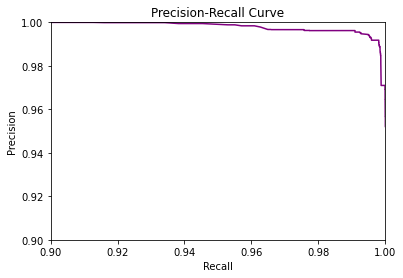

In [93]:
#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')
plt.xlim([0.90, 1])
plt.ylim([0.90, 1])

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

In [94]:
#https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/ suggestion on setting thresholds
from numpy import argmax
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (threshold[ix], fscore[ix]))

Best Threshold=0.672647, F-Score=0.995


In [95]:
#taking 1-best threshold
threshold = 0.3
y_pred2 = (y_pred[:, 1] > threshold).astype('float')

tn, fp, fn, tp = confusion_matrix(pred_pd['label'], y_pred2).ravel()

In [96]:
print("There are "+str(tn)+ " true negatives")
print("There are "+str(tp)+ " true positives")
print("There are "+str(fn)+ " false negatives")
print("There are "+str(fp)+ " false positives")

There are 119196 true negatives
There are 6362 true positives
There are 725 false negatives
There are 583 false positives


This is with the suggested threshold. The code above just changes our pandas dataframe, but you can adjust the threshold on the model with 
https://spark.apache.org/docs/3.1.3/api/python/reference/api/pyspark.ml.classification.RandomForestClassifier.html#pyspark.ml.classification.RandomForestClassifier.setThresholds 
so we loose presicion as we are loosing the some True Posatives in order to lower the false negative rate, which is more important in intrustion detection. The Mathews Correlation coeffiecent also rises. which is what we want to see and likely the metric I will use to judge my algorithims


In [97]:
precision,recall,fscore,support = precision_recall_fscore_support(pred_pd['label'], y_pred2, average='binary')
MCC2 = matthews_corrcoef(pred_pd['label'], y_pred2)
print("The precision is "+str(precision))
print("The recall is "+str(recall))
print("The fscore is "+str(fscore))
print("The Matthews correlation coefficient is "+str(MCC2))

The precision is 0.9160547156227502
The recall is 0.8977000141103428
The fscore is 0.9067844925883695
The Matthews correlation coefficient is 0.9013799805508445
